# 构建目标检测主干框架代码


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feature_inputs (InputLayer)     [(None, 10, 4356)]   0                                            
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 10, 660)      2875620     Feature_inputs[0][0]             
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 10, 16)       10576       dense_62[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 10, 16)       31696       dense_62[0][0]                   
___________________________________________________________________________________________

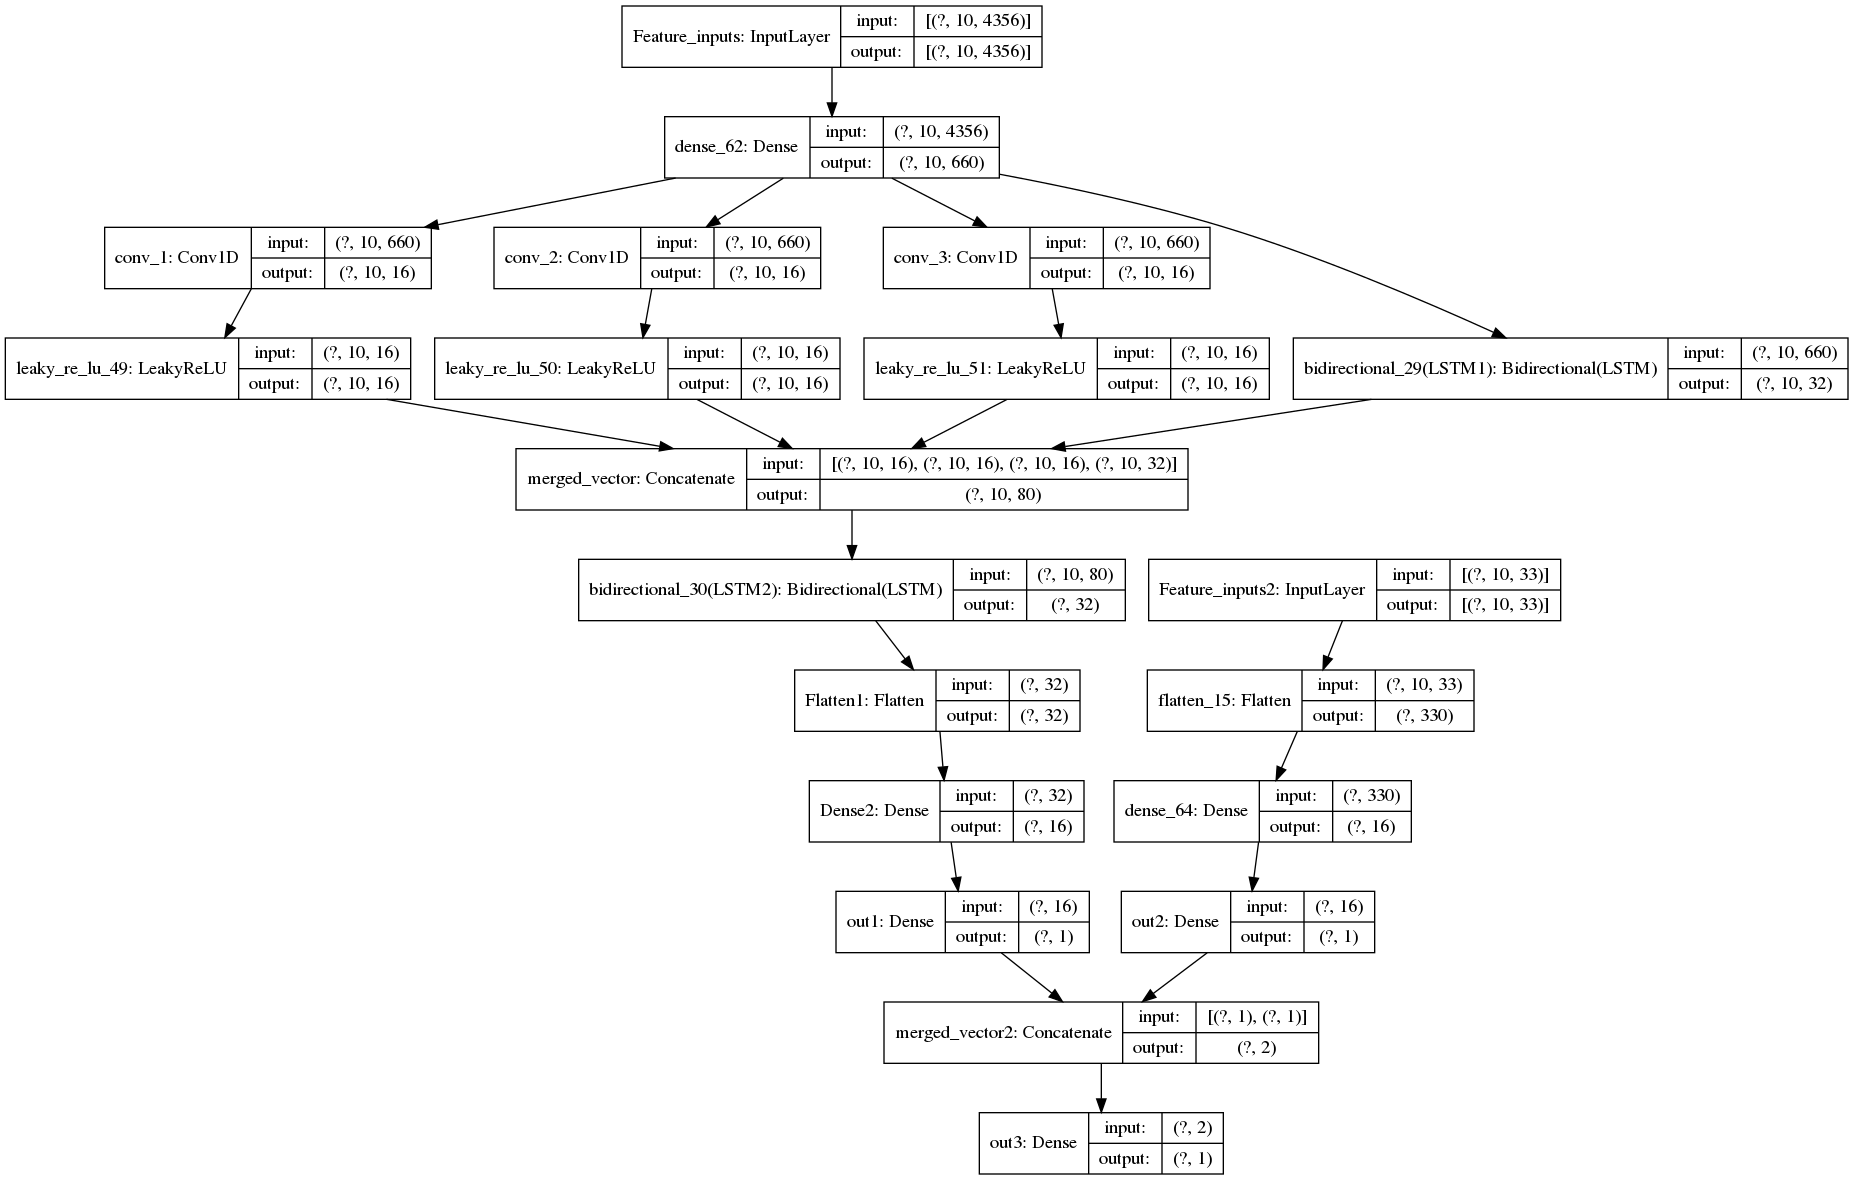

In [44]:
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf
# from spektral.layers import GraphConv
from tensorflow.keras.models import Model # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers


def build_model(input_seq_len=132, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam'
               ):
        
    # inputs
    Feature_inputs = L.Input(shape=(input_seq_len, 4356), name="Feature_inputs")
    Feature_inputs2 = L.Input(shape=(input_seq_len, 33), name="Feature_inputs2")

    Feature_inputs_new = L.Dense(660)(Feature_inputs)
    Feature_inputs_new2 = L.Dense(64)(Feature_inputs2)

    conv_1 = L.Conv1D(
        16, 1,
        padding='same',name="conv_1")(Feature_inputs_new)
    conv_1_1 = L.LeakyReLU()(conv_1)

    conv_2 = L.Conv1D(
        16,3,
        padding='same',name="conv_2")(Feature_inputs_new)
    conv_2_2 = L.LeakyReLU()(conv_2)

    
    conv_3 = L.Conv1D(
        16,4,
        padding='same',name="conv_3")(Feature_inputs_new)
    conv_3_3 = L.LeakyReLU()(conv_3)



    LSTM1 = L.Bidirectional(LSTM(16,input_shape=(input_seq_len,660),return_sequences=True,name='LSTM1'))(Feature_inputs_new)
    
    merged_vector = concatenate([conv_1_1, conv_2_2, conv_3_3, LSTM1], axis=-1,name="merged_vector")
    LSTM2 = L.Bidirectional(LSTM(16,name='LSTM2'))(merged_vector)
    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten1)
    out1 = Dense(1, activation='sigmoid',name="out1")(Dense2)
    
    Flatten2 = Flatten()(Feature_inputs2)
    Dense2 = Dense(16)(Flatten2)
    out2 = Dense(1,name='out2')(Dense2)
    
    merged_vector2 = concatenate([out1, out2], axis=-1,name="merged_vector2")
    out3 = Dense(1, activation='sigmoid',name="out3")(merged_vector2)
    
    model = Model(
        inputs=[
            Feature_inputs,Feature_inputs2
        ],
        outputs=out3,
    )
    model.compile(loss=losss,
                  optimizer=optimizerr,
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    return model

model = build_model(input_seq_len=10, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam')
tf.keras.utils.plot_model(model,to_file='1.png',show_shapes=True,show_layer_names=True)   

In [60]:

import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
# data
# https://github.com/XiuzeZhou/NASA/blob/main/RNN%20%26%20LSTM.ipynb
from scipy.io import loadmat
import scipy
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt



# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)  # 加载mat文件
    filename = matfile.split("/")[-1].split(".")[0]  # 以‘.’和‘/’为分隔符分割，分割出路径中的文件名
            # nasa_count_data/B0006.mat  ---》  B0006
    col = data[filename]  # dict_keys(['__header__', '__version__', '__globals__', 'B0006'])
    col = col[0][0][0][0]  # numpy   (1, 1 )  --->  (616,)  
    size = col.shape[0]

    data = []
    for i in range(size):
#         print(col.shape)
        k = list(col[i][3][0].dtype.fields.keys()) 
        # k:dict_keys(['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                        #'Current_charge', 'Voltage_charge', 'Time'])
        # “电压测量”、“电流测量”、“温度测量”、“电流充电”、“电压充电”、“时间”
        # col[i][0][0]  : 表示当前样本i的作业类别，放电、充电、阻抗
        # col[i][1][0]  : 表示当前样本i的作业温度
        # col[i][2][0]  : 表示当前样本i的作业日期，时间，'2008-04-02 13:08:17'
        # col[i][3][0]  : 表示当前样本i的作业六个参数值
        
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance': # 判断作业类型,非阻抗作业
            for j in range(len(k)):          # 遍历六个特征列
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l                 # 将读取到的数据放入对应的字典keys下
        d1['type'], d1['temp'] = str(col[i][0][0]), int(col[i][1][0])
        d1['time'], d1['data'] = str(convert_to_time(col[i][2][0])), d2
        data.append(d1)
    return data

# 提取锂电池容量
def getBatteryCapacity(Battery):
    # 电池容量在放电数据集 'discharge'的'Capacity'特征下；
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]  # 构成了(x, y)坐标系


# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [4]:
# 测试
dir_path = "nasa_count_data/"
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018',
               'B0025', 'B0026', 'B0027', 'B0028',
               'B0029', 'B0030', 'B0031', 'B0032',
               'B0033', 'B0034', 'B0036', 'B0038',
               'B0039', 'B0040', 'B0041', 'B0042',
               'B0043', 'B0044', 'B0045', 'B0046',
               'B0047', 'B0048', 'B0049', 'B0050',
               'B0051', 'B0052', 'B0053', 'B0054',
               'B0055', 'B0056'
               ]
for name in Battery_list:

    path = dir_path + name + '.mat'

    data = loadMat(path)
    python_y=np.array(data) #将matlab数据赋值给python变量
    c = 0
    d = 0
    im = 0
    for i in range(0,len(python_y)):
        if python_y[i]['type']=='charge': c+=1
        if python_y[i]['type']=='discharge': d+=1
        if python_y[i]['type']=='impedance': im+=1

    print('样本%s，总样本数：'%name,python_y.shape[0],'， 冲电记录次数：',c,'， 放电记录次数：',d,'， 阻抗记录次数：',im)

样本B0005，总样本数： 616 ， 冲电记录次数： 170 ， 放电记录次数： 168 ， 阻抗记录次数： 278
样本B0006，总样本数： 616 ， 冲电记录次数： 170 ， 放电记录次数： 168 ， 阻抗记录次数： 278
样本B0007，总样本数： 616 ， 冲电记录次数： 170 ， 放电记录次数： 168 ， 阻抗记录次数： 278
样本B0018，总样本数： 319 ， 冲电记录次数： 134 ， 放电记录次数： 132 ， 阻抗记录次数： 53
样本B0025，总样本数： 80 ， 冲电记录次数： 31 ， 放电记录次数： 28 ， 阻抗记录次数： 21
样本B0026，总样本数： 80 ， 冲电记录次数： 31 ， 放电记录次数： 28 ， 阻抗记录次数： 21
样本B0027，总样本数： 80 ， 冲电记录次数： 31 ， 放电记录次数： 28 ， 阻抗记录次数： 21
样本B0028，总样本数： 80 ， 冲电记录次数： 31 ， 放电记录次数： 28 ， 阻抗记录次数： 21
样本B0029，总样本数： 97 ， 冲电记录次数： 40 ， 放电记录次数： 40 ， 阻抗记录次数： 17
样本B0030，总样本数： 97 ， 冲电记录次数： 40 ， 放电记录次数： 40 ， 阻抗记录次数： 17
样本B0031，总样本数： 97 ， 冲电记录次数： 40 ， 放电记录次数： 40 ， 阻抗记录次数： 17
样本B0032，总样本数： 97 ， 冲电记录次数： 40 ， 放电记录次数： 40 ， 阻抗记录次数： 17
样本B0033，总样本数： 486 ， 冲电记录次数： 197 ， 放电记录次数： 197 ， 阻抗记录次数： 92
样本B0034，总样本数： 486 ， 冲电记录次数： 197 ， 放电记录次数： 197 ， 阻抗记录次数： 92
样本B0036，总样本数： 486 ， 冲电记录次数： 197 ， 放电记录次数： 197 ， 阻抗记录次数： 92
样本B0038，总样本数： 122 ， 冲电记录次数： 47 ， 放电记录次数： 47 ， 阻抗记录次数： 28
样本B0039，总样本数： 122 ， 冲电记录次数： 47 ， 放电记录次数： 47 ， 阻抗记录次数： 28
样本B0040，总样本数： 122 ， 冲电

In [5]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import * 
import tensorflow as tf
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))   #打印gpu信息
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())




1.15.0


In [6]:
dir_path = "nasa_count_data/"
# dataName = "B0005.mat"

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
# dir_path = 'dataset/'

capacity, charge, discharge = {}, {}, {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    print(len(data))
#     Battery[name] = getBatteryCapacity(data)   # 放电时的容量数据
    capacity[name] = getBatteryCapacity(data)              # 放电时的容量数据
    charge[name] = getBatteryValues(data, 'charge')        # 充电数据
    discharge[name] = getBatteryValues(data, 'discharge')  # 放电数据
# print(Battery['B0005'])




Load Dataset B0005.mat ...
616
Load Dataset B0006.mat ...
616
Load Dataset B0007.mat ...
616
Load Dataset B0018.mat ...
319


In [52]:
print(len(charge['B0007']),data[0]['time'])
print(len(capacity))

170 2008-07-07 12:26:45
4


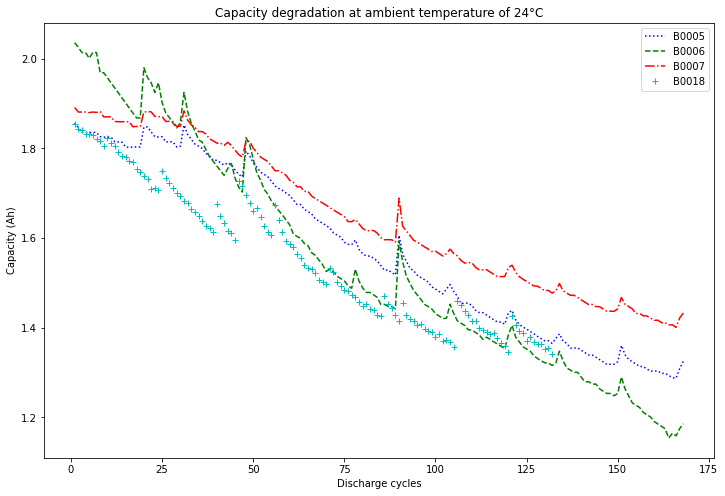

In [164]:
# 3. 容量 v.s. 充放电次数 曲线


fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c+']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = capacity[name]  # （循环次数， 当前容量）坐标
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

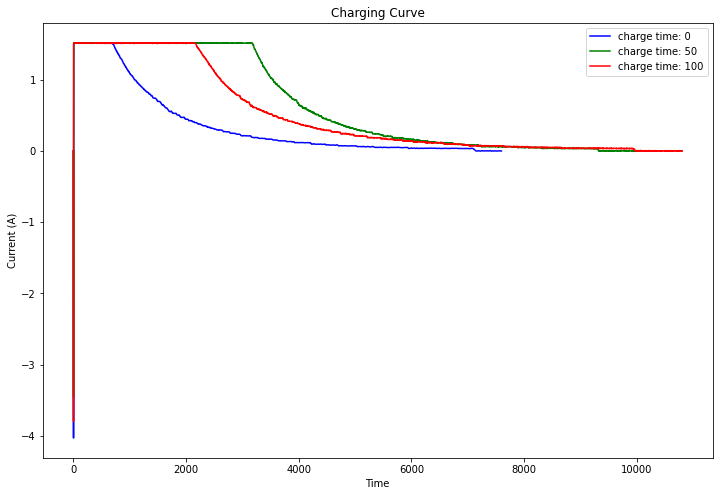

In [17]:
# 4. 充电电流 v.s. 充电时间 曲线


name = 'B0005'       #查看的电池号
time = [0, 50, 100] #查看的充电次数

# 画图
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b', 'g', 'r']
c = 0
for t in time:
    Battery = charge[name][t]
    color = color_list[c]
    ax.plot(Battery['Time'], Battery['Current_measured'], color, label='charge time: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Current (A)', title='Charging Curve')
plt.legend()

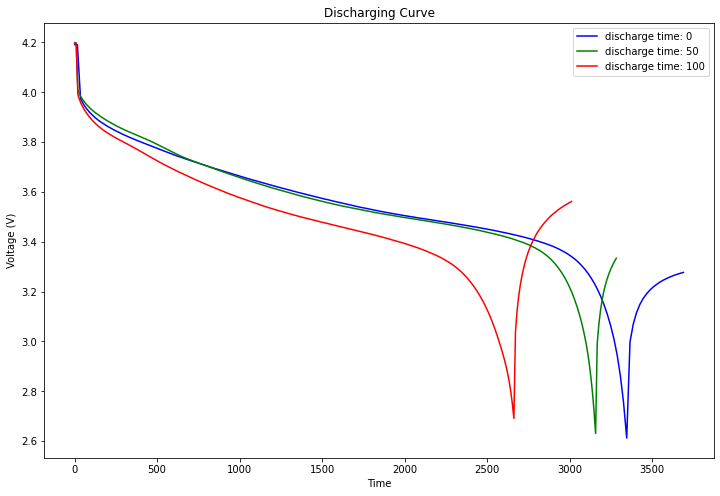

In [35]:
# 5. 放电电压 v.s. 充电时间 曲线


name = 'B0005'          #查看的电池号
time = [0, 50, 100]     #查看的放电次数

# 画图
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b', 'g', 'r']
c = 0
for t in time:
    Battery = discharge[name][t]
    color = color_list[c]
    ax.plot(Battery['Time'], Battery['Voltage_measured'], color, label='discharge time: '+str(t))
    c += 1
ax.set(xlabel='Time', ylabel='Voltage (V)', title='Discharging Curve')
plt.legend()

In [101]:
# CNN1D模型三特征
def build_model_cnn1d():
    
    # 定义输入
#     input_data_sm = Input(shape=(1,1), name='input_data_sm')
#     input_data_wh = Input(shape=(140,1), name='input_data_wh')
    input_data_full = Input(shape=(16,1), name='input_data_full')

    # WH处理分支
    cnn_out = Conv1D(filters=64, kernel_size=8, 
                     activation='relu',padding='same', input_shape=(16,1),name="cnn_out")(input_data_full)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(50, activation='sigmoid',name="Dense2")(Flatten2)
#     predictions = Dense(1, activation='sigmoid',name="predictions")(merged_vector)
    # 再在上面添加一个逻辑回归层
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)


    inputs = [input_data_full]
    # 定义一个连接推特输入和预测的可训练的模型
    model = Model(inputs, predictions1)  ####
#     model = Model(inputs, [predictions0,predictions1,predictions2])  ####

    model.compile(optimizer='adam',  #optimizers.Adam(lr=0.001,decay=0.004),
                  loss='mse',
                  metrics=['accuracy'])
    model.summary()
    x = 'CNN1D'
    return model,x

# LSTM
def build_model_LSTM():
    input_data_full = Input(shape=(16,1), name='input_data_full')
    LSTM1 = LSTM(64,input_shape=(16,1),return_sequences=True,name='LSTM1')(input_data_full)
    LSTM2 = LSTM(64,name='LSTM2')(LSTM1)
    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer='adam',
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'LSTM2'
    return model,x

# GRU
def build_model_GRU():
    input_data_full = Input(shape=(16,1), name='input_data_full')
    GRU1 = GRU(16,input_shape=(16,1),return_sequences=True,name='GRU1')(input_data_full)
    GRU2 = GRU(16,return_sequences=True,name='GRU2')(GRU1)
    GRU3 = GRU(16,name='GRU3')(GRU2)
    Flatten1 = Flatten(name="Flatten1")(GRU3)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer='adam',
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'GRU3'
    return model,x

In [102]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(window_size,len(text)):  # 【window_size:-1】
        if i<len(text):
            sequence = text[i - window_size:i]      # 特征
            target = text[i]    # 标签,延后的序列。。。？？？

            x.append(sequence)
            y.append(target)
        else:
            break
        
    return np.array(x), np.array(y)

# 数据集打包模块
# 打包当前sheet序列数据和标签
# 重叠打包策略
def createXY(dataset,n_past):
    """
        dataset：传入数据集；
        n_past：lstm的timestep，预测下一个目标值时将在过去查看的步骤数；
        index: 预测目标标签；
        trainX — — →trainY
        eg：
            [0 : 30,0:5] → [30,0]
            [1:31, 0:5] → [31,0]
            [2:32,0:5] →[32,0]
    """
#     print(dataset.shape,dataset.shape[1])
    n_past=int(n_past)
#     index=int(index)
    dataX = [] # 所有的特征值
    dataY = [] # 目标预测标签

#     print(len(dataset),dataset[168])
    for i in range(n_past, len(dataset)):
#         print()
        if i<len(dataset):
            dataX.append(dataset[i - n_past:i])
            dataY.append(dataset[i])
        else:
            break
    return np.array(dataX),np.array(dataY)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    
#     # 该部分是选取一个step_time序列为测试集
#     data_sequence=data_dict[name][1]
#     train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]  # 且分出训练数据和测试数据
#     train_x, train_y = build_sequences(text=train_data, window_size=window_size)   # 制作数据集特征和标签
    
    # 余下数据生成训练集

    count = 0
    for k, v in data_dict.items():  # 返回可遍历的(键, 值) 元组数组，然后便利
        data_x, data_y = build_sequences(text=v[1], window_size=window_size)
        if count==0:
            x, y = data_x, data_y
        else:
            x, y = np.r_[x, data_x], np.r_[y, data_y]
                            # np.r_：是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()。
                            # np.c_：是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
        count+=1
    return x, y

def shuffle_data(X,y):
    # shuffle数据集
    # X,y: 数据集样本和标签
    # return：shuffle后的特征和标签，以及打乱后的索引
    data_list=np.array(X)           # list of images
    label_list=np.array(y)           # list of labels

    ##如果image_list存的是读取的特征数据，而不是图片路径，不要注释后面两句（list无法索引内部list）
    #[list indices must be integers or slices, not list]
    #image_list = np.array(image_list)
    #label_list = np.array(label_list)

    index = [i for i in range(len(data_list))]
    np.random.shuffle(index)
    data = data_list[index]
    labels = label_list[index]
    return data, labels, index

B0005 test sample size: 572 (572, 16)
B0006 train sample size: 572 (572, 16)
B0007 train sample size: 572 (572, 16)
B0018 train sample size: 572 (572, 16)
(1716, 16) (1716,) (572, 16) (572,)
(1716, 16, 1) (1716,) (572, 16, 1) (572,)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data_full (InputLayer) [(None, 16, 1)]           0         
_________________________________________________________________
GRU1 (GRU)                   (None, 16, 16)            864       
_________________________________________________________________
GRU2 (GRU)                   (None, 16, 16)            1584      
_________________________________________________________________
GRU3 (GRU)                   (None, 16)                1584      
_________________________________________________________________
Flatten1 (Flatten)           (None, 16)                0         
________________________

Epoch 22/30
1688/1716 [============================>.] - ETA: 0s - loss: 0.3345 - acc: 0.0000e+00
Epoch 00022: loss improved from 0.33472 to 0.33472, saving model to ./test1/model_GRU3_1.hdf5
1716/1716 [==============================] - 2s 1ms/sample - loss: 0.3347 - acc: 0.0000e+00 - val_loss: 0.3347 - val_acc: 0.0000e+00
Epoch 23/30
1688/1716 [============================>.] - ETA: 0s - loss: 0.3364 - acc: 0.0000e+00
Epoch 00023: loss improved from 0.33472 to 0.33471, saving model to ./test1/model_GRU3_1.hdf5
1716/1716 [==============================] - 2s 1ms/sample - loss: 0.3347 - acc: 0.0000e+00 - val_loss: 0.3347 - val_acc: 0.0000e+00
Epoch 24/30
1688/1716 [============================>.] - ETA: 0s - loss: 0.3343 - acc: 0.0000e+00
Epoch 00024: loss improved from 0.33471 to 0.33471, saving model to ./test1/model_GRU3_1.hdf5
1716/1716 [==============================] - 2s 1ms/sample - loss: 0.3347 - acc: 0.0000e+00 - val_loss: 0.3347 - val_acc: 0.0000e+00
Epoch 25/30
1688/1716 [==

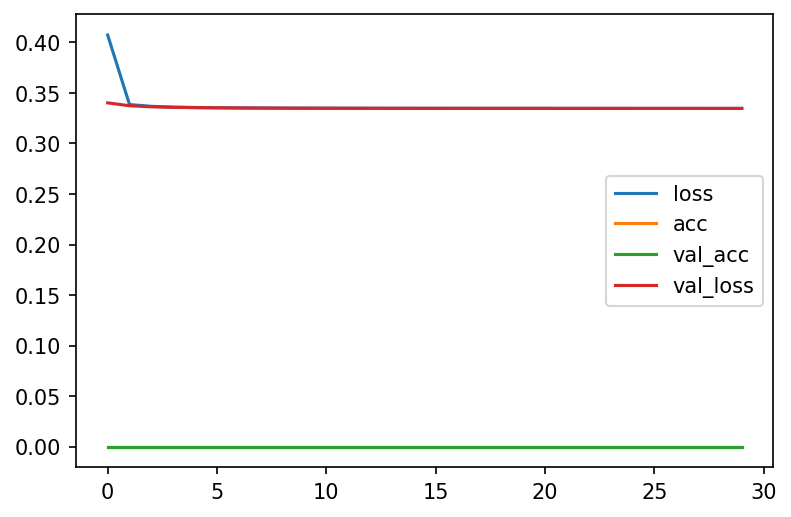

In [103]:
# keras-tf相关模块
import tensorflow as tf
from keras.models import load_model
from tensorflow.python.keras import backend as K  
from tensorflow.keras.models import * # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers
# from keras.layers import *
# 导入ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint,TensorBoard,Callback,ReduceLROnPlateau,EarlyStopping
# keras查看GPU模块
from keras.utils import *  # multi_gpu_model, plot_model
import time



# 单特征训练
def tain(lr=0.001, feature_size=16, hidden_dim=128, num_layers=2, 
         weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0, list_nums=4):
    # Battery_list ： 样本列表
    # Battery      ：【序号，电池容量】

    
    score_list, result_list = [], []
    
    # 训练数据准备
    test_x2, test_y2, train_x2, train_y2 = [], [], [], []
    count_train, count_test = 0, 0
    for i in range(list_nums):
        name = Battery_list[i]  # 样本列表
        # 划分数据集
        if i==0:
            test_x1, test_y1 = get_train_test(capacity, name, window_size=feature_size)
            test_size = len(test_x1)
            print('%s test sample size: {}'.format(test_size)%name,test_x1.shape)
            if count_test==0:
                test_x2, test_y2 = test_x1, test_y1
            else:
                test_x2, test_y2 = np.r_[test_x2, test_x1], np.r_[test_y2, test_y1]
            count_test+=1

        else:
            train_x1, train_y1 = get_train_test(capacity, name, window_size=feature_size)
            train_size = len(train_x1)
            print('%s train sample size: {}'.format(train_size)%name,train_x1.shape)
            if count_train==0:
                train_x2, train_y2 = train_x1, train_y1
            else:
                train_x2, train_y2 = np.r_[train_x2, train_x1], np.r_[train_y2, train_y1]
            count_train+=1
    print(train_x2.shape, train_y2.shape, test_x2.shape, test_y2.shape)
    train_x2, test_x2 = train_x2.reshape(train_x2.shape[0],feature_size,1), test_x2.reshape(test_x2.shape[0],feature_size,1)
    # shuffle 测试数据（样本后部分）
    train_x, train_y,_ = shuffle_data(train_x2, train_y2)
    test_x, test_y,_ = shuffle_data(test_x2, test_y2)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

    # 模型配置
    model,strr = build_model_GRU() 

    
    checkpoint_save_dir='./test1/'
    EarlyStop=EarlyStopping(monitor='loss'  #'val_acc',
                            ,patience=30,verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_%s_1.hdf5"%strr),
                                 monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint, EarlyStop]

    start_sampling = time.time()
    # hist_sampling = model.fit(X_train,y_train,
    hist_sampling = model.fit(train_x, train_y,
    #                           validation_split = 0.2, 
                              validation_data=(test_x, test_y),
                              batch_size=8, epochs=30, 
                              callbacks=callbacks_list,#,reduce_lr],
                              shuffle=True,
                              verbose=1)
    end_sampling = time.time()
    print('训练结束！！')
    print('训练时间（分钟）：',(end_sampling-start_sampling)/60)

    score_sampling = model.evaluate(test_x, test_y, batch_size=8)
    # score_sampling = model.evaluate(X_test,y_test, batch_size=128)
    print(score_sampling)
    plt.figure(dpi=150)
    plt.plot(hist_sampling.history['loss'], label='loss')
    plt.plot(hist_sampling.history['acc'], label='acc')
    plt.plot(hist_sampling.history['val_acc'], label='val_acc')
    plt.plot(hist_sampling.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
# 0.004 0.018
        
tain()
#         setup_seed(seed)
#         model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
#         model = model.to(device)

In [95]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):  # 【window_size:-1】
        sequence = text[i:i+window_size]      # 特征
        target = text[i+1:i+1+window_size]    # 标签,延后的序列。。。？？？

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    
    # 该部分是选取一个step_time序列为测试集
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]  # 且分出训练数据和测试数据
#     print(len(data_dict),len(data_sequence),len(train_data),len(test_data))
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)   # 制作数据集特征和标签
#     print(len(train_x[0]),len(train_y[0]))
    
    # 余下数据生成训练集
    for k, v in data_dict.items():  # 返回可遍历的(键, 值) 元组数组，然后便利
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
                            # np.r_：是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()。
                            # np.c_：是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
    return train_x, train_y, list(train_data), list(test_data)

# 相对误差
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    # 设置随机数种子，为所有的模式提供固定随机情况，使得实验课复现
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [62]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, n_class=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_class)
 
    def forward(self, x):           # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x) 
        out = out.reshape(-1, self.hidden_dim)
        out = self.linear(out)      # out shape: (batch_size, n_class=1)
        return out

In [194]:
from torchsummary import summary

def tain(lr=0.001, feature_size=16, hidden_dim=128, num_layers=2, 
         weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0):
    # Battery_list ： 样本列表
    # Battery      ：【序号，电池容量】

    
    score_list, result_list = [], []
    for i in range(4):
        name = Battery_list[i]  # 样本列表
        # 划分数据集
        train_x, train_y, train_data, test_data = get_train_test(capacity, name, window_size=feature_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        model = model.to(device)
#         net11 = model
#         summary(net11)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()  # 生成的测试集
        loss_list, y_ = [0], []     # 声明loss和pre容器
        mae, rmse, re = 1, 1, 1     # 初始化评价指标
        score_, score = 1,1         # 初始化评价列表
        
        for epoch in range(EPOCH):
            # 数据处理
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)
            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            
            output= model(X)                   # 预测结果
            output = output.reshape(-1, 1)
            loss = criterion(output, y)        # 计算loss
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy()    #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)                 # shape: (batch_size, 1, input_size)
                    
                    pred = model(x)
#                     print('???????????????????????/',pred.shape)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)                          #测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)                     #保存输出序列最后一个点的预测值
                y_.append(point_list)                                 #保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list,loss_list,model

In [195]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [196]:
window_size = 16     # step_time
EPOCH = 1000         
lr = 0.001           # learning rate
hidden_dim = 256     # 隐层维度，神经元个数
num_layers = 2       # 隐层层数
weight_decay = 0.0   # 学习率衰减
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0 # 额定容量
 
# 进行十次随机数固定实验，并输出loss\MAE\RMSE\RE
SCORE = []
RES = []
LOSS = []
seed = 0
# for seed in range(2):
#     print('seed: ', seed)
#     score_list, res, loss_list = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
#                          weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
#     print('------------------------------------------------------------------')
#     for s in score_list:  
#         SCORE.append(s)
# #     if seed == 2: LOSS.append(loss_list)
# # plt.plot(res, 'b', label='loss')


score_list, res, loss_list, model = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
print('------------------------------------------------------------------')
for s in score_list:  
    SCORE.append(s)

mlist = ['re', 'mae', 'rmse']
for i in range(3):
    s = [line[i] for line in SCORE] 
    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s)))) # 输出均值
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1099 | RMSE:0.1247 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.0914 | RMSE:0.1031 | RE:1.0000
epoch:299 | loss:0.0003 | MAE:0.0705 | RMSE:0.0830 | RE:0.0566
epoch:399 | loss:0.0002 | MAE:0.0563 | RMSE:0.0702 | RE:0.0755
4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0005 | MAE:0.1216 | RMSE:0.1448 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1183 | RMSE:0.1418 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1050 | RMSE:0.1253 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.1055 | RMSE:0.1217 | RE:1.0000
epoch:499 | loss:0.0001 | MAE:0.1188 | RMSE:0.1325 | RE:0.5889
epoch:599 | loss:0.0001 | MAE:0.1353 | RMSE:0.1486 | RE:0.6000
4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1338 | RMSE:0.1542 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1168 | RMSE:0.1289 | RE:0.1258
epoch:299 | loss:0.0003 | MAE:0.1216 | RMSE:0.1247 | RE:0.3444
4 132 17 115
16 16
sample size: 457
epoch:99 | loss:0.0007 | MAE:0.0566 | RM